In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
dolly_cqa_df = pd.read_parquet('./data/dolly_cqa_prepared.parquet')
dolly_cqa_df = dolly_cqa_df[dolly_cqa_df['fk_score_categ'] != 'medium']
dolly_cqa_df

,instruction,context,response,category,text,embeddings_mini_lm,embeddings_bge_large,fk_score,fk_score_categ
0,When did Virgin Australia start operating?,"Virgin Australia, the trading name of Virgin A...",Virgin Australia commenced services on 31 Augu...,closed_qa,"### CONTEXT ###\nVirgin Australia, the trading...","[0.07990753650665283, -0.04975801706314087, 0....","[0.5005730390548706, -0.46779343485832214, -1....",9.131896,easy
1,When was Tomoaki Komorida born?,Komorida was born in Kumamoto Prefecture on Ju...,"Tomoaki Komorida was born on July 10,1981.",closed_qa,### CONTEXT ###\nKomorida was born in Kumamoto...,"[-0.011252421885728836, -0.04460098594427109, ...","[0.64762282371521, 0.43752172589302063, -0.047...",7.643152,easy
4,Who was the first to record the Needles and Pi...,"""Needles and Pins"" is a rock song credited to ...",The first artist to record Needles and Pins so...,closed_qa,"### CONTEXT ###\n""Needles and Pins"" is a rock ...","[-0.08916875720024109, 0.0042908587493002415, ...","[-0.08973768353462219, -0.17643515765666962, 0...",9.573611,easy
7,"Does ""outbreeding"" or ""inbreeding"" benefit the...",Exogamy often results in two individuals that ...,"""Outbreeding"" is more beneficial to the offspr...",closed_qa,### CONTEXT ###\nExogamy often results in two ...,"[-0.03272196277976036, 0.059583552181720734, -...","[0.49220746755599976, 0.5510503649711609, -0.0...",16.317379,hard
8,When was the first Reading railway station ope...,Reading railway station is a major transport h...,The first Reading railway station was opened o...,closed_qa,### CONTEXT ###\nReading railway station is a ...,"[0.11136063933372498, -0.11817897856235504, 0....","[0.2983482778072357, -0.21368077397346497, 0.2...",10.092885,easy
...,...,...,...,...,...,...,...,...,...
1453,What would cause stride scheduling to cause in...,The stride scheduling is a type of scheduling ...,Blocking operations would cause dependency iss...,closed_qa,### CONTEXT ###\nThe stride scheduling is a ty...,"[-0.13380882143974304, 0.00896916538476944, -0...","[0.24260517954826355, 0.37313172221183777, -0....",13.784529,hard
1454,Given this paragraph about Yahalom and his wor...,Yahalom is the author of numerous books and ar...,"Based off of this paragraph, it is clear that ...",closed_qa,### CONTEXT ###\nYahalom is the author of nume...,"[-0.014189689420163631, 0.0727512314915657, 0....","[0.40544071793556213, -0.37684574723243713, 0....",14.159374,hard
1456,How many world championships has Max Verstappe...,"After winning the 2021 Abu Dhabi Grand Prix, V...",Max Verstappen has won 2 Formula One World Cha...,closed_qa,### CONTEXT ###\nAfter winning the 2021 Abu Dh...,"[0.044786978513002396, 0.0190593209117651, -0....","[0.5898312330245972, 0.14761556684970856, -0.4...",7.991569,easy
1459,What is linux Bootloader,"A bootloader, also spelled as boot loader or c...",A bootloader is a program written in machine c...,closed_qa,"### CONTEXT ###\nA bootloader, also spelled as...","[-0.05690043047070503, 0.05346180498600006, -0...","[0.32251039147377014, -0.2482924461364746, 0.0...",19.799659,hard


In [3]:
def train_lr_classifier(df, embeddings_col, y_col):
    # Convert the list of lists in X_colname to a numpy array
    X = np.array(df[embeddings_col].tolist())
    
    y = df[y_col]
    
    # Label encoding the target variable
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    
    # Initialize LR classifier
    clf = LogisticRegressionCV(cv=5, scoring='f1_macro', max_iter=10000, n_jobs=-1)

    # Fit the classifier
    clf.fit(X, y_encoded)

    return le, clf

In [4]:
le, clf = train_lr_classifier(df=dolly_cqa_df, embeddings_col='embeddings_mini_lm', y_col='fk_score_categ')

In [5]:
def get_predictions(df, le, clf, embeddings_col, y_col):
    # Convert the list of lists in X_colname to a numpy array
    X = np.array(df[embeddings_col].tolist())
    
    y = df[y_col]

    # Label encoding the target variable
    y_encoded = le.transform(y)

    # Predictions
    y_pred_encoded = clf.predict(X)

    # Reverse-transform the predicted and actual labels to their original values
    y_pred = le.inverse_transform(y_pred_encoded)
    y_test = le.inverse_transform(y_encoded)

    # Printing the classification report
    print(classification_report(y_test, y_pred))

    # Plotting the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(7,5))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

              precision    recall  f1-score   support

        easy       0.86      0.88      0.87       487
        hard       0.88      0.85      0.87       487

    accuracy                           0.87       974
   macro avg       0.87      0.87      0.87       974
weighted avg       0.87      0.87      0.87       974



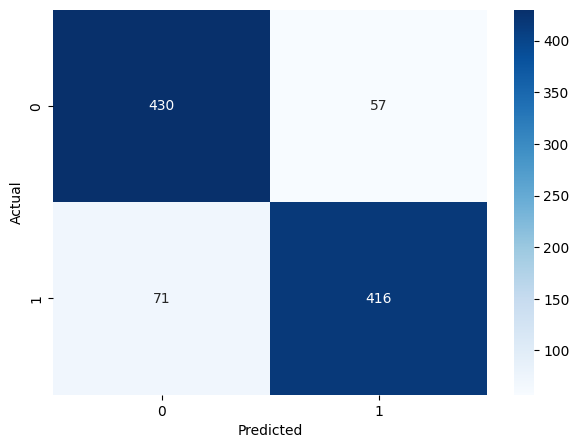

In [6]:
get_predictions(df=dolly_cqa_df, le=le, clf=clf, embeddings_col='embeddings_mini_lm', y_col='fk_score_categ')

In [7]:
# dolly_cqa_df['score_easy'] = clf.predict_proba(X=np.array(dolly_cqa_df['embeddings_bge_large'].tolist()))[:,0]
# dolly_cqa_df['score_hard'] = clf.predict_proba(X=np.array(dolly_cqa_df['embeddings_bge_large'].tolist()))[:,1]
# dolly_cqa_df['score_medium'] = clf.predict_proba(X=np.array(dolly_cqa_df['embeddings_bge_large'].tolist()))[:,2]

# dolly_cqa_df['w_easy_embeddings'] = dolly_cqa_df['embeddings_bge_large'].apply(lambda x: x * clf.coef_[0])
# dolly_cqa_df['w_hard_embeddings'] = dolly_cqa_df['embeddings_bge_large'].apply(lambda x: x * clf.coef_[1])
# dolly_cqa_df['w_medium_embeddings'] = dolly_cqa_df['embeddings_bge_large'].apply(lambda x: x * clf.coef_[2])
# dolly_cqa_df['iw_easy_embeddings'] = dolly_cqa_df['embeddings_bge_large'].apply(lambda x: x / clf.coef_[0])
# dolly_cqa_df['iw_hard_embeddings'] = dolly_cqa_df['embeddings_bge_large'].apply(lambda x: x / clf.coef_[1])
# dolly_cqa_df['iw_medium_embeddings'] = dolly_cqa_df['embeddings_bge_large'].apply(lambda x: x / clf.coef_[2])

dolly_cqa_df['score'] = clf.predict_proba(X=np.array(dolly_cqa_df['embeddings_mini_lm'].tolist()))[:,1]
dolly_cqa_df['w_embeddings'] = dolly_cqa_df['embeddings_mini_lm'].apply(lambda x: x * clf.coef_[0])
dolly_cqa_df['iw_embeddings'] = dolly_cqa_df['embeddings_mini_lm'].apply(lambda x: x / clf.coef_[0])

In [ ]:
def get_cluster_stats(df, cluster_col, score_col):
    return df.groupby(cluster_col).agg(
        score_mean=pd.NamedAgg(column=score_col, aggfunc='mean'), 
        score_std =pd.NamedAgg(column=score_col, aggfunc='std')
    ).reset_index(drop=False).rename(columns={cluster_col: 'cluster_id'})

n_clusters = 20
seed=0
uw_kmeans = KMeans(n_clusters=n_clusters, random_state=seed, n_init="auto").fit( [v for v in dolly_cqa_df['embeddings_mini_lm']])
w_kmeans = KMeans(n_clusters=n_clusters, random_state=seed, n_init="auto").fit( [v for v in dolly_cqa_df['w_embeddings']])
iw_kmeans = KMeans(n_clusters=n_clusters, random_state=seed, n_init="auto").fit( [v for v in dolly_cqa_df['iw_embeddings']])

dolly_cqa_df['uw_kmeans'] = uw_kmeans.labels_
dolly_cqa_df['w_kmeans'] = w_kmeans.labels_
dolly_cqa_df['iw_kmeans'] = iw_kmeans.labels_

# cs_unweighted = get_cluster_stats(dd2, 'unweighted_kmeans', 'score')
# cs_weighted = get_cluster_stats(dd2, 'weighted_kmeans', 'score')
# cs_inverse_weighted = get_cluster_stats(dd2, 'inverse_weighted_kmeans', 'score')

In [9]:
cluster_df = dolly_cqa_df[['uw_kmeans', 'w_kmeans', 'iw_kmeans', 'score']]
cluster_df = pd.melt(cluster_df, id_vars=['score'], var_name='weighting', value_name='cluster_id')
cluster_df = cluster_df.groupby(["weighting", "cluster_id"]).mean().reset_index()

[Text(0, 0.5, '')]

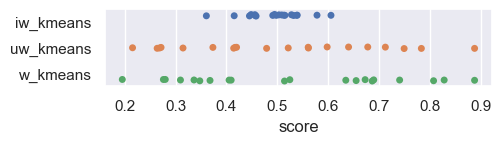

In [10]:
sns.set(rc={"figure.figsize":(5, 1)})
ax = sns.stripplot(x='score', y='weighting', data=cluster_df, jitter=True, hue='weighting', dodge=True, legend=False)
ax.set(ylabel=None)

In [11]:
cluster_df[['weighting', 'score']].groupby('weighting').std() # standard deviation of mean scores across clusters

,score
weighting,
iw_kmeans,0.056027
uw_kmeans,0.194472
w_kmeans,0.211330


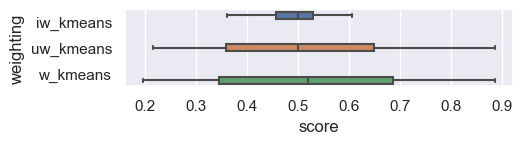

In [12]:
g = sns.boxplot(x='score', y ='weighting', data = cluster_df, hue ='weighting')
g.legend([],[], frameon=False)